# Scene Recognition with Deep Learning

## Outline
In this project, we will use *convolutional neural nets* to classify images into different scenes.

Basic learning objectives:
1. Construct the fundamental pipeline for performing deep learning using PyTorch;
2. Understand the concepts behind different layers, optimizers.
3. Experiment with different models and observe the performance.

## Colab Setup

In [7]:
use_colab_paths = False # switch to True if you're using colab

## Dataset
The dataset is in the ```data``` folder. It has two subfolders: ```train``` and ```test```. Go through any of the folder there are the folders with scene names like *bedroom*, *forest*, *office*. These are the 15 scenes that we want our model to predict given an image. All this data is labelled data provided to you for training and testing your model.

## Setup

In [8]:
import os
import torch
import matplotlib.pyplot as plt

from trainer import Trainer
from model import (get_optimizer, SimpleNet, SimpleNetDropout, MyAlexNet, 
ImageLoader, get_fundamental_transforms, get_data_augmentation_transforms)
from utils import compute_mean_and_std, visualize

%load_ext autoreload
%autoreload 2

In [10]:
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available() # will turn off cuda if the machine doesnt have a GPU
print("GPU available:", is_cuda)

GPU available: False


In [11]:
data_base_path = '../data/' if not use_colab_paths else 'data/'
model_base_path = '../model_checkpoints/' if not use_colab_paths else 'model_checkpoints/'

In [12]:
print(os.listdir(data_base_path))
print(os.listdir(model_base_path))

# TODO: check that these outputs are as per expectation. It will save a lot of time in debugging issues.

['test', 'train']
['simple_net', 'quantized_alexnet', 'simple_net_dropout', 'alexnet']


To train a network in PyTorch, we need 4 components:
1. **Dataset** - an object which can load the data and labels given an index.
2. **Model** - an object that contains the network architecture definition.
3. **Loss function** - a function that measures how far the network output is from the ground truth label.
4. **Optimizer** - an object that optimizes the network parameters to reduce the loss value.

## Datasets
One crucial aspect of deep learning is to perform data preprocessing. In DL, we usually *normalize* the dataset and perform some *transformations* on them. The transformations can either help the inputs be compatible with the model (say our model only works on 500x500 images and we need all input to be cropped/scaled to this size) or help in data-augmentation to improve performance (more on this later).


### Compute mean and standard deviation of the dataset
In any machine learning task it is a good practice to normalize the features to a fixed range. In this project we are going to "zero-center" and "normalize" the dataset so that each entry has zero mean and the overall standard deviation is 1. 



In [13]:
dataset_mean, dataset_std = compute_mean_and_std(data_base_path)

In [14]:
print('Dataset mean = {}, standard deviation = {}'.format(dataset_mean, dataset_std))

Dataset mean = [0.45547487], standard deviation = [0.25316328]


### ImageLoader

Now let's create the **Datasets** object to be used later during training. We have to load each image as well as its classification ground-truth label. The essence is to retrieve the paths to all the images required, and be able to provide the **path** and the **class id** when given an index.

In [15]:
# Initialize a new image loader instance of the 'test' dataset
# For train dataset, use 'train' for split
input_size = (64, 64)
image_loader = ImageLoader(data_base_path, 
                           split='test',
                          )

In [16]:
# Length of the dataset, returned by the __len__() function in ImageLoader class
print("Length of dataset: ", len(image_loader))

Length of dataset:  1500


In [17]:
# Classes in the dataset, returned by get_classes() function in ImageLoader class
print("Classes: ", image_loader.get_classes())

Classes:  {'forest': 0, 'bedroom': 1, 'office': 2, 'highway': 3, 'coast': 4, 'insidecity': 5, 'tallbuilding': 6, 'industrial': 7, 'street': 8, 'livingroom': 9, 'suburb': 10, 'mountain': 11, 'kitchen': 12, 'opencountry': 13, 'store': 14}


Lets take a look at the data type of the image and label returned from the image_loader.

In [18]:
sample_image, sample_label = next(iter(image_loader))
print("data type of sample_image : {}".format(type(sample_image)))
print("sample label : {}".format(sample_label))

data type of sample_image : <class 'PIL.Image.Image'>
sample label : 0


### Data transforms
Now we will construct some fundamental transforms to process images into torch tensors, which we can provide as input to our model.

1. Resize the input image to the desired shape;
2. Convert it to a tensor;
3. Normalize them based on the computed mean and standard deviation. 

After we implemented fundamental transform, pass these as tranforms and reinstantiate our image_loader

In [20]:
input_size = (64, 64)
image_loader = ImageLoader(data_base_path, 
                           split='test', 
                           transform=get_fundamental_transforms(input_size, dataset_mean, dataset_std)
                          )

In [21]:
# Create an iterator and get the 0th item, returned by __getitem__() function in ImageLoader class
sample_image, sample_label = next(iter(image_loader))
print('Input image shape = ', sample_image.shape)
print('Label index = ', sample_label)

Input image shape =  torch.Size([1, 64, 64])
Label index =  0


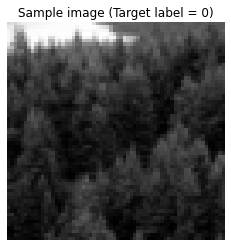

In [22]:
# Show the image of the 0th item in the dataset
fig, axs = plt.subplots()
axs.imshow(sample_image.squeeze().numpy(), cmap='gray')
axs.axis('off')
axs.set_title('Sample image (Target label = {})'.format(sample_label))
plt.show()


## Model Architecture and Forward Pass

### SimpleNet Model

Now we are preparing to move to the actual core of deep learning: the architecture. To get you started in this part, simply define a **2-layer** model in the class `SimpleNet` in `model.py`. Here by "2 layers" we mean **2 convolutional layers**, so we need to figure out the supporting utilities like ReLU, Max Pooling, and Fully Connected layers, and configure them with proper parameters to make the tensor flow.

We can refer the image *simplenet.jpg* in the base folder for a sample network architecture.

**NOTE** : More hints in doc string of SimpleNet. Also, the doc of pytorch [here](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#) can be helpful. Feel free to explore more on the internet.

### Test the model structure

Let's see what out model's forward function produces for a sample input, and how it relates to classification. Pytorch's convolution and FC layers are initialized with random weights. So we should not expect any useful output without any training.

We will use a data-point from the dataloader we have already created and run the model on it.

In [24]:
# Initialize SimpleNet
simple_model = SimpleNet()

In [25]:
# Get the 0th sample
sample_image, sample_label = next(iter(image_loader))

In [26]:
sample_input = sample_image.unsqueeze(0)
print("input dimension: ", sample_input.shape)

input dimension:  torch.Size([1, 1, 64, 64])


In [27]:
# run the image through the model
sample_model_output = simple_model(sample_input).detach()

In [28]:
print(sample_model_output)

tensor([[-0.0693, -0.0380, -0.0271,  0.0419, -0.0437, -0.0951, -0.0137, -0.0098,
          0.0450,  0.0157, -0.0652, -0.0547,  0.0224,  0.0748,  0.0589]])


In [29]:
print("output dimension: ", sample_model_output.shape)

output dimension:  torch.Size([1, 15])


We have a 15-dimensional tensor as output, but how does it relate to classification?

We first convert the this tensor into a probability distribution over 15 classes by applying the [Softmax](https://en.wikipedia.org/wiki/Softmax_function) operation.

In [30]:
sample_probability_values = torch.nn.functional.softmax(sample_model_output, dim=1)

In [31]:
print(sample_probability_values)

tensor([[0.0628, 0.0648, 0.0655, 0.0702, 0.0644, 0.0612, 0.0664, 0.0666, 0.0704,
         0.0684, 0.0630, 0.0637, 0.0688, 0.0725, 0.0714]])


The prediction of the model will be the index where the probability distribution is the maximum. Convince yourself that the argmax-operation on *sample_model_output* is the same as the argmax-operation on *sample_probability_values*.

## Loss function

We have written a model which takes in a tensor for an image and produces a 15 dimensional output for it. We saw in the previous section on how the output relates to the prediction and probability distribution. But how do we quantify the performance of the model, and how do we use that quantification to form an objective function which we can minimize.

Ideally, we would want the probability function to have value 1 for the target *sample_label* and value 0 for the remaining class indices. To penalize the deviation between the desired probability distribution and the model-predicted distrtibution, we use the KL-divergence loss or the cross-entropy loss. Please refer to [this stackexchange post](https://datascience.stackexchange.com/questions/20296/cross-entropy-loss-explanation) for a good explanation and derivation.

**Assign a loss function to ```self.loss_criterion``` in ```__init__()``` function of the class ```SimpleNet```.
Note that we have not done a softmax operation in the model's forward function and choose the [appropriate loss function](https://pytorch.org/docs/stable/nn.html#loss-functions).



In [32]:
simple_model = SimpleNet()

In [33]:
print(simple_model)

SimpleNet(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=500, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=15, bias=True)
  )
  (loss_criterion): CrossEntropyLoss()
)


## Optimizer

### Manual gradient descent using Pytorch's autograd

Till now, we have defined the model, and designed a loss function which is a proxy for *good* classification. We now have to optimize the weights of the network so that the loss function is minimized.

Pytorch is a very useful library for deep learning because a lot of tensor operations and functions support the flow of gradients. This feature is called [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). This functionality lets us use gradient based optimization techniques like gradient descent without writing a lot of code.

Let us first understand how we can access the gradients.

### Define a model and a loss function
Suppose we have a simple objective function that looks like:
$$ L(w) =  w^2 - 10w + 25 $$

This is a convex problem, and we know that the loss $L$ is minimized for $w=5$, and we can obtain this in closed form by setting the derivative wrt $w$ to $0$ and solving.

But let us use gradient descent to obtain the solution in this case.

In [35]:
import torch
from torch import tensor

def quadratic_loss(w: tensor) -> tensor:
    assert w.shape==(1,)

    # loss function
    L = torch.pow(w, 2) - 10 * w + 25
    
    return L

Let's compute the loss at w = 0.

In [36]:
w = tensor([0.0], requires_grad=True)

loss = quadratic_loss(w)

print('w={:.4f}\tLoss={:.4f}'.format(w.detach().numpy().item(), loss.detach().numpy().item()))

w=0.0000	Loss=25.0000


Now we can do a backward pass of the gradients to get the gradient of loss w.r.t w. Now we need to calculate the gradients with respect to the weights and biases using backprop. It will be very painful to do it manually, but thankfully, in PyTorch we've got it covered with autograd, which only needs a simple call of **.backward()** on our loss.

In [37]:
# perform backward pass on loss (we need to retain graph here otherwise Pytorch will throw it away)
loss.backward(retain_graph=True)

print(w.grad.data)

# manually zero out the gradient
w.grad.zero_()
pass

tensor([-10.])


With the gradients, we can update the weights and biases using gradient descent:
$$w_{k+1}=w_{k} - \alpha\frac{\partial L}{\partial w_k}$$
where $w$ is the parameter we are updating, $\alpha$ is the learning rate, and $\frac{\partial L}{\partial w_k}$ is the gradient at step $k$.

In [38]:
# set learning rate
lr = .03

def gradientDescentStep(w: tensor, L: tensor, lr: float=1e-3) -> None:
    '''
    Take a step of the gradient descent
    '''
    
    # manually zero out the gradient
    w.grad.zero_()

    # perform backward on loss (we need to retain graph here otherwise Pytorch will throw it away)
    L.backward(retain_graph=True)
    
    with torch.no_grad():
        w -= lr * w.grad

Let's take one step of the gradient descent and check if the the loss value decreased

In [39]:
loss = quadratic_loss(w)

gradientDescentStep(w, loss, lr) 

In [40]:
loss = quadratic_loss(w)
print('w={:.4f}\tLoss={:.4f}'.format(w.detach().numpy().item(), loss.detach().numpy().item()))

w=0.3000	Loss=22.0900


Looks like it's been optimized!

Now let's run a few more updates and see where we can get!

In [41]:
import time


start = time.time()
for i in range(200):
    loss = quadratic_loss(w)
    if not (i+1)%10:
        print('Iteration {}: w={:.4f}\tLoss={:.4f}'.format(
            i+1, w.detach().numpy().item(), loss.detach().numpy().item()))
        
    gradientDescentStep(w, loss, lr) 
        
print('\noptimization takes %0.3f seconds'%(time.time()-start))

Iteration 10: w=2.3069	Loss=7.2527
Iteration 20: w=3.5495	Loss=2.1040
Iteration 30: w=4.2187	Loss=0.6104
Iteration 40: w=4.5792	Loss=0.1771
Iteration 50: w=4.7733	Loss=0.0514
Iteration 60: w=4.8779	Loss=0.0149
Iteration 70: w=4.9342	Loss=0.0043
Iteration 80: w=4.9646	Loss=0.0013
Iteration 90: w=4.9809	Loss=0.0004
Iteration 100: w=4.9897	Loss=0.0001
Iteration 110: w=4.9945	Loss=0.0000
Iteration 120: w=4.9970	Loss=0.0000
Iteration 130: w=4.9984	Loss=0.0000
Iteration 140: w=4.9991	Loss=0.0000
Iteration 150: w=4.9995	Loss=0.0000
Iteration 160: w=4.9997	Loss=0.0000
Iteration 170: w=4.9999	Loss=0.0000
Iteration 180: w=4.9999	Loss=0.0000
Iteration 190: w=5.0000	Loss=-0.0000
Iteration 200: w=5.0000	Loss=0.0000

optimization takes 0.049 seconds


Seems that it's doing a great job training our model! The loss now has decreased significantly to a pretty small value.

### Optimization using Pytorch's gradient descent optimizer

Now let's see how we can simplify this using the `torch.optim` package from PyTorch. You can see that using optimizer from `torch.optim` package can achieve the same results with a lot less code from our side. Also, there are many features available over the vanilla gradient descent. Let's use the Stochastic Gradient Descent (SGD) optimizer available in Pytorch.

In [42]:
from torch.optim import SGD

# define parameters we want to optimize
w = tensor([0.0], requires_grad=True)

optimizer = SGD([w], lr=lr)

start = time.time()
for i in range(200):
    loss = quadratic_loss(w)   
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if not (i+1)%10:
        print('Iteration {}: w={:.4f}\tLoss={:.4f}'.format(
            i+1, w.detach().numpy().item(), loss.detach().numpy().item()))
        
print('\noptimization takes %0.3f seconds'%(time.time()-start))

Iteration 10: w=2.3069	Loss=8.2081
Iteration 20: w=3.5495	Loss=2.3812
Iteration 30: w=4.2187	Loss=0.6908
Iteration 40: w=4.5792	Loss=0.2004
Iteration 50: w=4.7733	Loss=0.0581
Iteration 60: w=4.8779	Loss=0.0169
Iteration 70: w=4.9342	Loss=0.0049
Iteration 80: w=4.9646	Loss=0.0014
Iteration 90: w=4.9809	Loss=0.0004
Iteration 100: w=4.9897	Loss=0.0001
Iteration 110: w=4.9945	Loss=0.0000
Iteration 120: w=4.9970	Loss=0.0000
Iteration 130: w=4.9984	Loss=0.0000
Iteration 140: w=4.9991	Loss=0.0000
Iteration 150: w=4.9995	Loss=0.0000
Iteration 160: w=4.9997	Loss=0.0000
Iteration 170: w=4.9999	Loss=0.0000
Iteration 180: w=4.9999	Loss=0.0000
Iteration 190: w=5.0000	Loss=0.0000
Iteration 200: w=5.0000	Loss=0.0000

optimization takes 0.047 seconds


### Setting up the optimizer for SimpleNet

We will now set up a utility function to define an optimizer on the loss for a model.

We need to define parameters such as - the optimizer type we want to use ( sgd, adam, etc. ), learning rate, weight decay, etc.

Here, we have initialized them to *placeholder* values for now. Train the model with these values and it will be bad. Then come back here and tune the parameters. We will revisit this part again later to tune these inorder to improve our classification. 

In [43]:
# Add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 3e-4,
  "weight_decay": 1e-3
}

In [44]:
optimizer = get_optimizer(simple_model, optimizer_config)

In [45]:
assert(optimizer is not None)

## Training SimpleNet

Now we have completed all the components required to train the our model. Let's pass in the model architecture, optimizer, transforms for both the training and testing datasets into the trainer, and proceed to the next cell to train it.

We will use the ``Trainer`` class from ```trainer.py``` file which contains all the essential functions for training, plotting the accuracies. 

In [46]:
# re-init the model so that the weights are all random
simple_model = SimpleNet()
optimizer = get_optimizer(simple_model, optimizer_config)
input_size = (64,64)
trainer = Trainer(data_dir=data_base_path, 
                  model = simple_model,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'simple_net'),
                  train_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

In [47]:
import time
simple_net_start = time.time()
trainer.train(num_epochs=20)
simple_net_end = time.time()
print("The training time taken for simple net is {:.9f}".format(simple_net_end-simple_net_start))

Epoch:0, Training Loss:2.7065, Validation Loss:2.7077
Epoch:1, Training Loss:2.4624, Validation Loss:2.5286
Epoch:2, Training Loss:2.2329, Validation Loss:2.3354
Epoch:3, Training Loss:1.9731, Validation Loss:2.1225
Epoch:4, Training Loss:1.7824, Validation Loss:1.9840
Epoch:5, Training Loss:1.7098, Validation Loss:1.9267
Epoch:6, Training Loss:1.6500, Validation Loss:1.8865
Epoch:7, Training Loss:1.5541, Validation Loss:1.8179
Epoch:8, Training Loss:1.5043, Validation Loss:1.7848
Epoch:9, Training Loss:1.4339, Validation Loss:1.7200
Epoch:10, Training Loss:1.4245, Validation Loss:1.7225
Epoch:11, Training Loss:1.3849, Validation Loss:1.7819
Epoch:12, Training Loss:1.3124, Validation Loss:1.6765
Epoch:13, Training Loss:1.2715, Validation Loss:1.6686
Epoch:14, Training Loss:1.2305, Validation Loss:1.6767
Epoch:15, Training Loss:1.2770, Validation Loss:1.7285
Epoch:16, Training Loss:1.1633, Validation Loss:1.6834
Epoch:17, Training Loss:1.1692, Validation Loss:1.6969
Epoch:18, Training L

Now let's have the model predict on some examples and see how well it performs qualitatively. Try the following cell multiple times to understand whats happening.

Examples from train split:


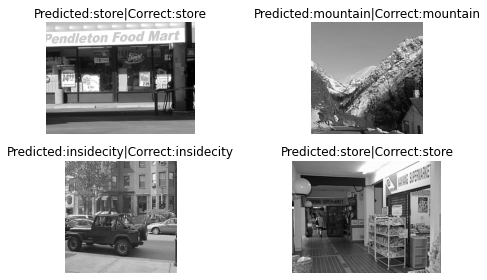

In [48]:
# Visualize train split
print("Examples from train split:")
visualize(simple_model, 'train', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path)

Examples from test split:


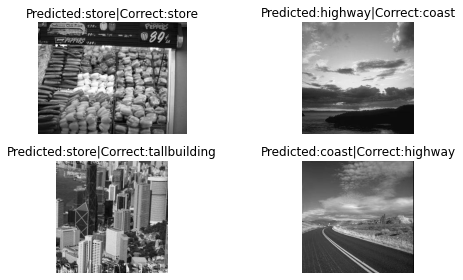

In [49]:
# Visualize test split
print("Examples from test split:")
visualize(simple_model, 'test', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path)

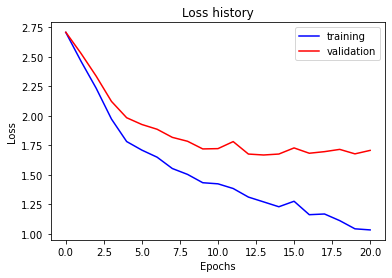

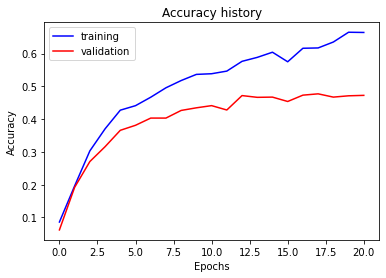

In [50]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [51]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.6647; Validation Accuracy = 0.4727


After finished the training process, now plot out the loss and accuracy history. We can check out the final accuracy for both training and validation data. 

## Pretrained AlexNet
We can see that with our basic 2-layer SimpleNet, we were able to classify the images. However, we are not satisfied with its performance yet. We could add other techniques like Dropout which we defer to Extra Credit. 

We are going to take a different approach at the task now. Our model, in the end, is still a 2-layer SimpleNet and it might be capable of capturing some features, but it could be improved a lot if we go **deeper**. In this part, we are going to see the power of a famous model: AlexNet.

### Data Augmentation with Jitter, Random Flip, and Normalization

Before diving into using Alexnet, we could do something to increase the amount of data samples we have. Since, having more data is always better.

One common and simple technique to achieve it is to **augment** it. Firstly, let's "jitter" it; secondly, we will use the fact that when *mirror* an image of a kitchen, we can tell that the mirrored image is still a kitchen. 

In [56]:
augmentation_transforms = get_data_augmentation_transforms((64, 64), dataset_mean, dataset_std )

In [57]:
assert(len(augmentation_transforms.transforms) > 0)

### Building AlexNet
PyTorch has provided us with pre-trained models like AlexNet, so what we want to do is to load the model first, and then adjust some of the layers such that it fits with our own dataset, instead of outputing scores to 1000 classes from the original AlexNet model.

There are many reasons for using pre-trained weights instead of training AlexNet from scratch:
1. We have a really small dataset ( even after augmenting ). Alexnet has millions of parameters and will definitely overfit. The pre-trained alexnet will have access to millions of training images.
2. We save a lot of computation.

After we have defined the correct architecture of the model, make some tweaks to the existing layers: **freeze** the **convolutional** layers and first 2 **linear** layers so we don't update the weights of them.

In [58]:
my_alexnet = MyAlexNet()
print(my_alexnet)

MyAlexNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.

### Training AlexNet
We will now train the `AlexNet`.

As done before, we initialize parameters for optimizer for AlexNet which we need to tune later to improve the performance.

In [131]:
# Add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 3e-4,
  "weight_decay": 1e-3
}

In [143]:
my_alexnet = MyAlexNet()
optimizer = get_optimizer(my_alexnet, optimizer_config)
input_size = (224, 224)

trainer = Trainer(data_dir=data_base_path, 
                  model = my_alexnet,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'alexnet'),
                  train_data_transforms = get_data_augmentation_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

The following training cell will take roughly 20 minutes or slightly more using CPU (but possibly under 5 minute using GPU depending on the batch size.

In [144]:
trainer.train(num_epochs=5)

Epoch:0, Training Loss:2.9601, Validation Loss:2.9256
Epoch:1, Training Loss:0.4455, Validation Loss:0.5616
Epoch:2, Training Loss:0.3233, Validation Loss:0.4562
Epoch:3, Training Loss:0.2584, Validation Loss:0.4029
Epoch:4, Training Loss:0.2130, Validation Loss:0.3838
Epoch:5, Training Loss:0.1873, Validation Loss:0.3606


Now let's have the model predict on some examples and see how well it performs qualitatively.

Examples from train split:


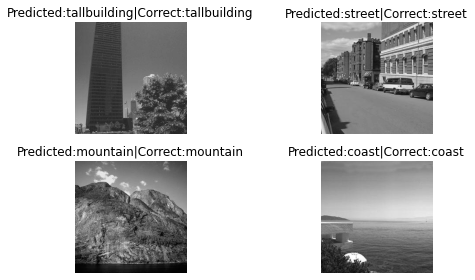

In [145]:
# Visualize train split
print("Examples from train split:")
visualize(my_alexnet, 'train', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path=data_base_path)

Examples from test split:


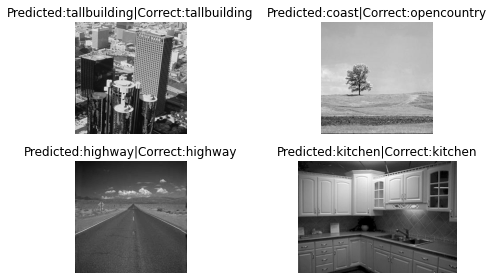

In [146]:
# Visualize test split
print("Examples from test split:")
visualize(my_alexnet, 'test', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path=data_base_path)

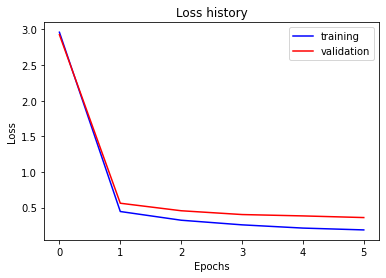

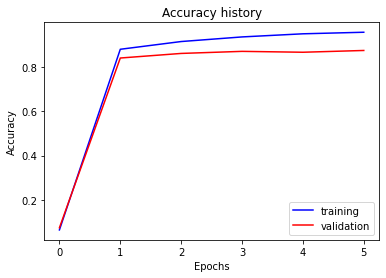

In [147]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [148]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.9554; Validation Accuracy = 0.8733


## Dropout

### Overfitting
We have obtained a 45% accuracy on the validation data with a SimpleNet; If you observe, it has good training accuracy (more than 90%, if you have implemented everything correctly) but not so great validation accuracy.

Our final accuracies for training and validation data differ a lot from each other, which indicates that the model we defined **fits too well with the training data, but is unable to generalize well on data it has not trained on**: this is often regarded as **overfitting** where the models fits the training data a little too well. We have some techniques to tackle with it: adjusting both data and model.

We have seen how to adjust the data by using data augmentation. Now we will see how to adjust the model itself. "Dropout" is a technique commonly used to regularize the network. It randomly turns off the connection between neurons inside the network and prevent the network from relying too much on a specific neuron.
Now we test the class `SimpleNetDropout`. It should be same as our previous SimpleNet model, except the dropout layer.

In [98]:
simple_model_dropout = SimpleNetDropout()
print(simple_model_dropout)

SimpleNetDropout(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=500, out_features=100, bias=True)
    (2): Dropout(p=0.5, inplace=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=15, bias=True)
  )
  (loss_criterion): CrossEntropyLoss()
)


Similar to the previous parts, **initialize the following cell with proper values for learning rate and weight decay** for SimpleNetDropout

In [178]:
# Add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 4.5e-4,
  "weight_decay": 1.5e-3
}

In [179]:
simple_model_dropout = SimpleNetDropout()
optimizer = get_optimizer(simple_model_dropout, optimizer_config)
input_size = (64,64)
trainer = Trainer(data_dir=data_base_path, 
                  model = simple_model_dropout,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'simple_net_dropout'),
                  train_data_transforms = get_data_augmentation_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

The following cell will take longer than that of SimpleNet, as now we have more data (and more variability), and the model is slightly more complicated than before as well; however, it should finish within 10~15 minutes anyway, and the default `num_epochs` of **30** is also good enough as a starting point for you to pass this part.

In [184]:
trainer.train(num_epochs=30)

Epoch:0, Training Loss:2.7209, Validation Loss:2.7214
Epoch:1, Training Loss:2.5728, Validation Loss:2.6459
Epoch:2, Training Loss:2.3797, Validation Loss:2.4517
Epoch:3, Training Loss:2.1613, Validation Loss:2.2841
Epoch:4, Training Loss:2.0107, Validation Loss:2.1126
Epoch:5, Training Loss:1.8731, Validation Loss:2.0155
Epoch:6, Training Loss:1.7823, Validation Loss:1.9307
Epoch:7, Training Loss:1.7268, Validation Loss:1.8766
Epoch:8, Training Loss:1.6898, Validation Loss:1.8607
Epoch:9, Training Loss:1.6497, Validation Loss:1.8014
Epoch:10, Training Loss:1.5832, Validation Loss:1.7529
Epoch:11, Training Loss:1.5451, Validation Loss:1.7354
Epoch:12, Training Loss:1.5031, Validation Loss:1.6763
Epoch:13, Training Loss:1.4762, Validation Loss:1.6661
Epoch:14, Training Loss:1.4589, Validation Loss:1.6475
Epoch:15, Training Loss:1.4350, Validation Loss:1.6409
Epoch:16, Training Loss:1.4145, Validation Loss:1.6196
Epoch:17, Training Loss:1.4015, Validation Loss:1.6169
Epoch:18, Training L

Now let's have your model predict on some examples and see how well it performs qualitatively.

Examples from train split:


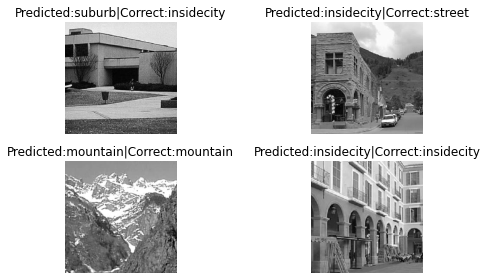

In [185]:
# Visualize train split
print("Examples from train split:")
visualize(simple_model_dropout, 'train', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path=data_base_path)

Examples from test split:


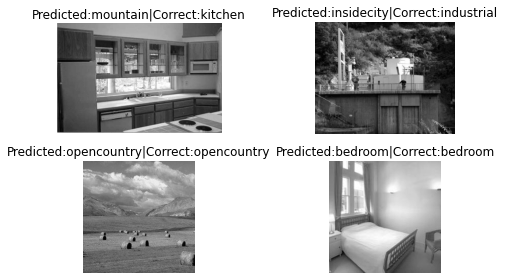

In [186]:
# Visualize test split
print("Examples from test split:")
visualize(simple_model_dropout, 'test', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path=data_base_path)

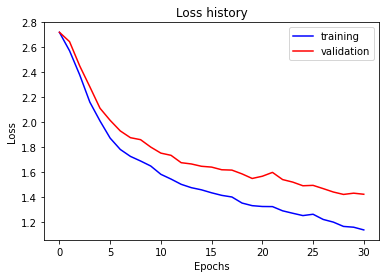

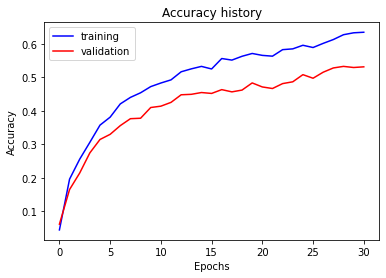

In [187]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [188]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.6345; Validation Accuracy = 0.5313


## Model Space/Compute improvement

We have created the AlexNet model which performs really well. But, can we deploy on a robot which does not have access to powerful GPUs and memory ? What if we want to make the model simpler and faster for inference. One option will be to use SimpleNet or a variant of it. But that has very low accuracy compared to AlexNet.

Can we utilize the AlexNet model which we have learnt and improve the memory/compute usage? This is an active research area with [several possible options](https://arxiv.org/pdf/1710.09282.pdf).

In this part, we will try quantizing our filter weights from 32-bit floating point to 8-bit integer. As you can guess, all the weights in the layers (in convolution and fully connected layers) will have a 75% reduction from this simple switch.

What about compute time? The first benefit is directly from lower memory foot-print. We can transfer more weights in the fixed memory bandwith and the cache can hold more weights too. Some CPU architectures might have INT8 computation units which can offer more speedup.

We might lose some accuracy when we sacrifice precision. Doing the fp32->int8 conversion directly is a bad choice. 
Suppose an activation is in a small range of $[0.1, 0.2]$. We cannot just round the weights as the activation might be the same for all the inputs. Hence we need to quantize based on the statistics of the activations.

In [192]:
from model import quantize_model

In [193]:
original_model = MyAlexNet().to('cpu')

In [194]:
input_size = (224, 224)
alexnet_trainer = Trainer(data_dir=data_base_path, 
                  model = original_model,
                  optimizer = get_optimizer(original_model, optimizer_config),
                  model_dir = os.path.join(model_base_path, 'alexnet'),
                  train_data_transforms = get_data_augmentation_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = True,
                  cuda = False
                 )

In [195]:
image_loader = ImageLoader(data_base_path, 
                           split='train', 
                           transform=get_fundamental_transforms(input_size, dataset_mean, dataset_std)
                          )

In [207]:
quantized_alexnet = quantize_model(original_model, image_loader)

In [208]:
quantized_alexnet_trainer = Trainer(data_dir=data_base_path, 
                  model = quantized_alexnet,
                  optimizer = get_optimizer(original_model, optimizer_config),
                  model_dir = os.path.join(model_base_path, 'quantized_alexnet'),
                  train_data_transforms = get_data_augmentation_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = False
                 )

quantized_alexnet_trainer.save_model()

### Size comparison

In [198]:
quantized_alexnet_size = os.path.getsize(os.path.join(model_base_path, 'quantized_alexnet', 'checkpoint.pt'))/1e6
alexnet_size = os.path.getsize(os.path.join(model_base_path, 'alexnet', 'checkpoint.pt'))/1e6

In [199]:
print('Original Alexnet Size: {:.2f}'.format(alexnet_size))
print('Quantized Alexnet Size: {:.2f}'.format(quantized_alexnet_size))
print('Percentage reduction: {:.2f}%'.format(100-100*quantized_alexnet_size/alexnet_size))

Original Alexnet Size: 228.76
Quantized Alexnet Size: 57.26
Percentage reduction: 74.97%


Now let's have our model predict on some examples and see how well it performs qualitatively.

### Processing Time comparison

In [200]:
import time

def time_forward_pass(model: torch.nn.Module, input_tensor: torch.tensor) -> float:
    model.eval()
    start = time.time()
    for _ in range(300):
        model(input_tensor)
    end = time.time()
    
    return (end-start)/300

In [201]:
sample_input, _ = next(iter(image_loader))
sample_input = sample_input.unsqueeze(0)

In [202]:
quantized_alexnet_time = time_forward_pass(quantized_alexnet, sample_input)

In [203]:
alexnet_time = time_forward_pass(original_model, sample_input)

In [204]:
print('Original Alexnet Time: {:.2f}'.format(alexnet_time))
print('Quantized Alexnet Time: {:.2f}'.format(quantized_alexnet_time))
print('Percentage reduction: {:.2f}%'.format(100-100*quantized_alexnet_time/alexnet_time))

Original Alexnet Time: 0.03
Quantized Alexnet Time: 0.01
Percentage reduction: 62.73%


### Accuracy comparison

In [205]:
_, alexnet_accuracy = alexnet_trainer.evaluate()
_, quantized_alexnet_accuracy = quantized_alexnet_trainer.evaluate()

In [206]:
print('Original Alexnet Accuracy: {:.2f}'.format(alexnet_accuracy))
print('Quantized Alexnet Accuracy: {:.2f}'.format(quantized_alexnet_accuracy))
print('Percentage reduction: {:.2f}%'.format(100-100*quantized_alexnet_accuracy/alexnet_accuracy))

Original Alexnet Accuracy: 0.87
Quantized Alexnet Accuracy: 0.87
Percentage reduction: 0.61%
